In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import pickle
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

from src.data.data_fetcher import get_all_features, get_raw_data
from src.features.feature_engineering import prepare_data
from src.features.preprocess_data import get_preprocessed_test_data, fetch_preprocessed_data
pd.set_option('display.max_columns', 200)


from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')


%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\gunna\Documents\Maskinlæring\Prosjekt\power-predictor\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
train_a, train_b, train_c, X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, X_test_estimated_a, X_test_estimated_b, X_test_estimated_c = get_raw_data()

X_train_obs_combined, X_val_obs_combined, y_train_obs_combined, y_val_obs_combined, X_train_est_combined, X_val_est_combined, y_train_est_combined, y_val_est_combined = fetch_preprocessed_data()
x_test_whole = get_preprocessed_test_data()

x_whole = pd.concat([X_train_obs_combined, X_val_obs_combined, X_train_est_combined, X_val_est_combined])
y_whole = pd.concat([y_train_obs_combined, y_val_obs_combined, y_train_est_combined, y_val_est_combined])
x_whole.reset_index(drop=True, inplace=True)
y_whole.reset_index(drop=True, inplace=True)


x_whole_obs = pd.concat([X_train_obs_combined, X_val_obs_combined])
y_whole_obs = pd.concat([y_train_obs_combined, y_val_obs_combined])

x_whole_est = pd.concat([X_train_est_combined, X_val_est_combined])
y_whole_est = pd.concat([y_train_est_combined, y_val_est_combined])

x_whole.head(10)

X_test_estimated_a.shape = (2880, 47), X_test_estimated_b.shape = (2880, 47), X_test_estimated_c.shape = (2880, 47)
After temporal alignment
X_test_estimated_a.shape = (720, 47), X_test_estimated_b.shape = (720, 47), X_test_estimated_c.shape = (720, 47)
X_test_estimated_a_processed.shape = (720, 46), X_test_estimated_b_processed.shape = (720, 46), X_test_estimated_c_processed.shape = (720, 46)


,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,is_day:idx,is_in_shadow:idx,precip_5min:mm,precip_type_5min:idx,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sun_azimuth:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,location_a,location_b,location_c,sin_day_of_year,cos_day_of_year,sin_hour,cos_hour,sun_product,modified_solar_elevation,effective_radiation,time_since_prediction,cloud_ratio,cloud_cover_over_30%,sun_addition,is_freezing,is_snow,is_rain
0,15.200,1.18175,1.351672e+06,440.600006,7231.174805,0.0,291.250000,95.500000,294605.531250,271.225006,8.723576e+05,54.224998,1.0,0.00,0.0000,0.00,1007.500000,0.000,0.0,72.375000,92.172501,0.000,294.625000,98.925003,48152.375000,2.125,-2.000,-0.750,0.0,1,0,0,0.027950,-0.999609,1.000000,6.123234e-17,25901.988281,0.455669,0.645392,0.0,0.548142,1,366.725006,0,0,0
1,13.700,1.19250,2.456032e+06,637.599976,1410.500000,0.0,289.399994,145.525009,447652.687500,5.800000,1.174988e+04,99.675003,1.0,0.00,0.0000,0.00,1001.400024,0.000,0.1,80.699997,236.257751,0.100,292.100006,100.000000,5903.875000,1.350,-1.225,0.525,0.0,0,1,0,-0.310857,-0.950457,-0.500000,-8.660254e-01,844.045105,0.611489,0.004784,0.0,0.996750,1,151.325012,0,0,0
2,10.500,1.20150,2.172293e+05,107.400002,2315.000000,0.0,285.299988,42.200001,100314.656250,65.099998,1.359929e+05,23.299999,1.0,0.00,0.0000,0.00,1006.849976,0.000,0.0,59.049999,85.390503,0.000,291.700012,43.549999,49974.699219,3.375,-0.400,3.350,0.0,1,0,0,-0.804826,-0.593511,0.965926,2.588190e-01,2747.219971,0.164161,0.626034,0.0,0.535017,0,107.300003,0,0,0
3,6.300,1.24800,0.000000e+00,0.000000,131.375000,0.0,277.100006,0.000000,0.000000,0.000000,0.000000e+00,99.574997,0.0,1.00,0.0000,0.00,992.949951,0.000,0.0,93.650002,127.701752,0.350,278.100006,99.974998,3399.375000,6.000,5.950,-0.500,0.0,1,0,0,-0.141444,0.989946,0.965926,-2.588190e-01,0.000000,0.000000,0.000000,0.0,0.995999,1,0.000000,0,0,0
4,6.300,1.27175,0.000000e+00,0.000000,8580.474609,0.0,277.000000,0.000000,0.000000,0.000000,0.000000e+00,49.400002,0.0,1.00,0.0000,0.00,1012.200012,0.000,0.0,81.649994,346.724243,0.000,278.600006,98.824997,27873.150391,1.450,1.450,-0.275,0.0,1,0,0,0.931210,-0.364483,-0.500000,8.660254e-01,0.000000,0.000000,0.000000,0.0,0.499874,1,0.000000,0,0,0
5,4.025,1.28000,1.452865e+04,14.250000,844.275024,0.0,270.700012,8.875000,15948.400391,4.425000,7.955200e+03,9.575000,1.0,0.75,0.0000,0.00,994.125000,0.000,0.0,90.824997,135.347992,0.000,273.625000,9.575000,37888.300781,2.300,1.250,1.925,0.0,0,1,0,0.537677,0.843151,0.866025,-5.000000e-01,39.271877,0.032549,0.547553,0.0,1.000000,0,13.300000,0,0,0
6,5.550,1.27250,0.000000e+00,0.000000,3068.200195,0.0,275.274994,0.000000,0.000000,0.000000,0.000000e+00,58.000000,0.0,1.00,0.0000,0.00,1017.000000,0.000,0.0,50.400002,331.056000,0.000,283.750000,98.875000,33853.199219,0.750,-0.200,0.725,0.0,0,1,0,0.968251,-0.249981,-0.707107,7.071068e-01,0.000000,0.000000,0.000000,0.0,0.586599,1,0.000000,0,0,0
7,4.325,1.28750,0.000000e+00,0.000000,0.000000,-0.5,271.700012,0.000000,0.000000,0.000000,0.000000e+00,4.775000,0.0,1.00,0.0000,0.00,1009.450012,1.875,0.0,64.400002,44.770248,0.000,279.549988,8.950000,34397.699219,1.600,0.125,1.600,0.0,0,0,1,0.954067,-0.299595,0.500000,8.660254e-01,0.000000,0.000000,0.000000,0.0,0.533520,0,0.000000,0,0,0
8,7.225,1.24150,0.000000e+00,0.000000,1859.074951,0.0,279.250000,0.000000,0.000000,0.000000,0.000000e+00,99.900002,0.0,1.00,0.0175,0.75,1002.549988,0.000,0.0,77.925003,284.348236,0.075,282.600006,100.000000,33559.425781,1.650,-1.050,1.300,0.0,1,0,0,-0.985056,0.172236,-1.000000,-1.836970e-16,0.000000,0.000000,0.000000,0.0,0.999000,1,0.000000,0,0,1
9,12.000,1.16950,2.868621e+06,819.275024,9663.500000,0.0,287.725006,129.52499

In [3]:
x_whole_obs.shape

(77044, 46)

In [4]:
x_whole_est.shape

(10832, 46)

In [5]:
def multi_predict(x_values :pd.DataFrame, models) -> pd.DataFrame:
    """
    Function for predicting on multiple models and averaging the results
    """
    results = models[0].predict(x_values)
    for model in models[1:]:
        model: xgb.XGBRegressor
        prediction = model.predict(x_values)
        results += prediction
    
    results = results / len(models)

    return results


## Train K folds

In [6]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

num_folds = 5

# Combine key factors to create a stratification variable without modifying the original DataFrame
location = np.where(x_whole['location_a'], 'A',
                    np.where(x_whole['location_b'], 'B',
                             np.where(x_whole['location_c'], 'C', '')))
weather_type = np.where(x_whole['time_since_prediction'] == 0, 'Observed', 'Estimated')
stratification_var = np.core.defchararray.add(location, weather_type)

# Initialize StratifiedKFold with 5 folds
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
total_mae = 0

reg_models = []

for train_index, test_index in skf.split(x_whole, stratification_var):

    reg = xgb.XGBRegressor(n_estimators=10000000,
                       early_stopping_rounds=50,
                       learning_rate= 0.001,
                       objective="reg:linear",
                       eval_metric="mae",
                       sub_sample = 0.9,
                       colsample_bytree = 1.0,
                       gamma = 0,
                       min_child_weight=0,
                       max_depth=9)

    X_train, X_test = x_whole.iloc[train_index], x_whole.iloc[test_index]
    y_train, y_test = y_whole.iloc[train_index], y_whole.iloc[test_index]
    
    # Create sample weights for training data
    sample_weight_train = np.where(X_train['time_since_prediction'] == 0, 1, 2)
    # Create sample weights for testing data
    sample_weight_test = np.where(X_test['time_since_prediction'] == 0, 1, 2)
    
    reg.fit(X_train, y_train,
            eval_set=[(X_test, y_test)],
            sample_weight=sample_weight_train,
            sample_weight_eval_set=[sample_weight_test],  # Here's how you pass the eval weights
            verbose=100)
    
    reg_models.append(reg)
    predictions = reg.predict(X_test)
    
    mae = mean_absolute_error(y_test, predictions, sample_weight=sample_weight_test)
    total_mae += mae
    
    print(f"Fold {total_mae}, Mean Absolute Error: {mae}")

average_mse = total_mae / num_folds
print(f"Average Mean Squared Error: {average_mse}")


[0]	validation_0-mae:402.16200
[100]	validation_0-mae:366.32794
[200]	validation_0-mae:334.30398
[300]	validation_0-mae:305.78224
[400]	validation_0-mae:280.46455
[500]	validation_0-mae:258.00887
[600]	validation_0-mae:238.12257
[700]	validation_0-mae:220.55908
[800]	validation_0-mae:204.90322
[900]	validation_0-mae:190.94637
[1000]	validation_0-mae:178.55743
[1100]	validation_0-mae:167.49497
[1200]	validation_0-mae:157.65614
[1300]	validation_0-mae:148.83263
[1400]	validation_0-mae:140.94652
[1500]	validation_0-mae:133.95451
[1600]	validation_0-mae:127.74197
[1700]	validation_0-mae:122.19997
[1800]	validation_0-mae:117.25171
[1900]	validation_0-mae:112.77541
[2000]	validation_0-mae:108.80767
[2100]	validation_0-mae:105.26862
[2200]	validation_0-mae:102.10293
[2300]	validation_0-mae:99.29867
[2400]	validation_0-mae:96.74540
[2500]	validation_0-mae:94.44149
[2600]	validation_0-mae:92.38243
[2700]	validation_0-mae:90.52867
[2800]	validation_0-mae:88.87370
[2900]	validation_0-mae:87.35587

In [7]:
# import xgboost as xgb
# from sklearn.metrics import mean_absolute_error

# # List to store the models
# reg_models = []

# # Loop over 5 seeds to create 5 models
# for i in range(5):
#     reg = xgb.XGBRegressor(n_estimators=30000,
#                            learning_rate=0.001,
#                            objective="reg:linear",
#                            eval_metric="mae",
#                            subsample=0.9,
#                            colsample_bytree=1.0,
#                            gamma=0,
#                            min_child_weight=0,
#                            max_depth=9,
#                            random_state=i)  # Set different random state for each model
    
#     reg.fit(x_whole, y_whole,
#             verbose=100)
    
#     reg_models.append(reg)


In [8]:
# y_predictions = multi_predict(x_test_whole, reg_models)

# from src.models.saving import save_predictions


# save_predictions(y_predictions, 'xgboost all dataen 5 modeller 2')

## Feature importance

<Figure size 20000x10000 with 0 Axes>

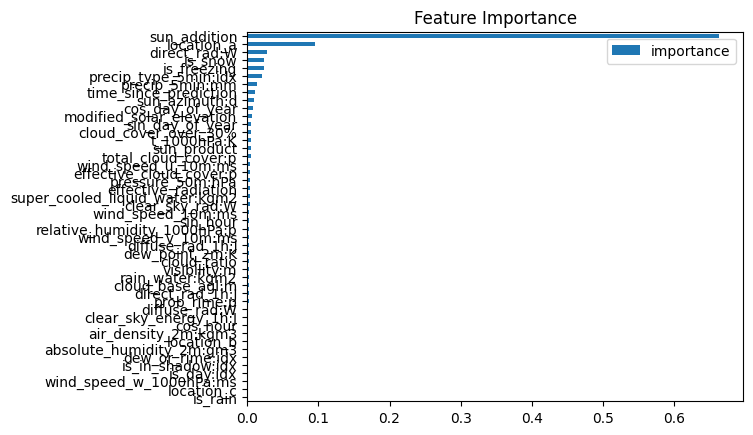

In [9]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=["importance"])

plt.figure(figsize=(200,100))
plt.tight_layout()
fi.sort_values("importance").plot(kind="barh", title="Feature Importance")
plt.show()

In [10]:
def multi_predict(x_values :pd.DataFrame, models) -> pd.DataFrame:
    """
    Function for predicting on multiple models and averaging the results
    """
    results = models[0].predict(x_values)
    for model in models[1:]:
        model: xgb.XGBRegressor
        prediction = model.predict(x_values)
        results += prediction
    
    results = results / len(models)

    return results


In [11]:
print(f"Average fold MAE: {average_mse}")


y_pred_val_obs_combined = multi_predict(x_whole_obs, reg_models)
y_pred_val_est_combined = multi_predict(x_whole_est, reg_models)

# Evaluate the model's performance using Mean Absolute Error (MAE) on the combined validation observed data
mae_obs_combined = mean_absolute_error(y_whole_obs, y_pred_val_obs_combined)
mae_est_combined = mean_absolute_error(y_whole_est, y_pred_val_est_combined)
print('MAE on observed data: ', mae_obs_combined)
print('MAE on estimated data: ', mae_est_combined)



mae_est_list = []

for i, reg in enumerate(reg_models):
    # Extract test indices for the current fold
    _, test_index = list(skf.split(x_whole, stratification_var))[i]
    
    # Extract estimated data from the test split
    X_test_est = x_whole.iloc[test_index][x_whole['time_since_prediction'] != 0]
    y_test_est = y_whole.iloc[test_index][x_whole['time_since_prediction'] != 0]
    
    # Predict on the estimated data in the test split
    y_pred_est = reg.predict(X_test_est)
    
    # Calculate MAE for the estimated data
    mae_est = mean_absolute_error(y_test_est, y_pred_est)
    mae_est_list.append(mae_est)
    # print(f'Fold {i+1}, MAE on estimated data: {mae_est}')

# Calculate the average MAE for the estimated data across all folds
average_mae_est = np.mean(mae_est_list)
print('Average MAE on estimated data across all folds: ', average_mae_est)

Average fold MAE: 68.09892990389282
MAE on observed data:  33.54172530586601
MAE on estimated data:  14.788571647258022
Average MAE on estimated data across all folds:  42.54104205707638


#Save Model


In [12]:
with open("xgboost_models.pkl", "wb") as file:
    pickle.dump(reg_models, file)

In [13]:
with open("xgboost_models.pkl", "rb") as file:
    loaded_reg_models = pickle.load(file)

In [14]:
# Predict on the cleaned validation set

y_predictions = multi_predict(x_test_whole, loaded_reg_models)



## Visualization  

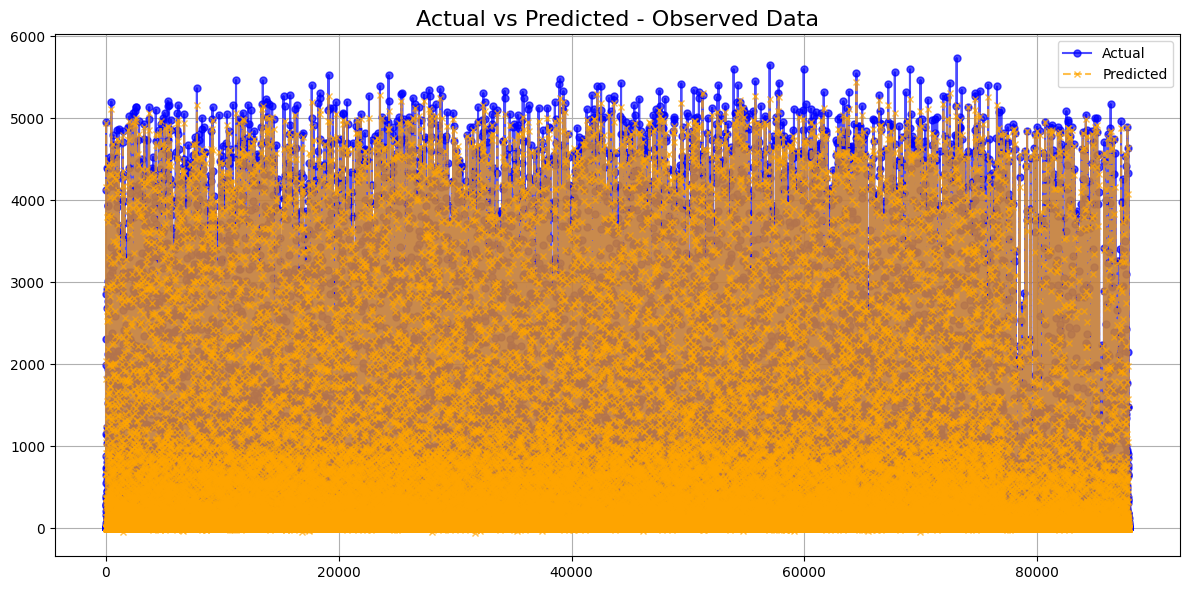

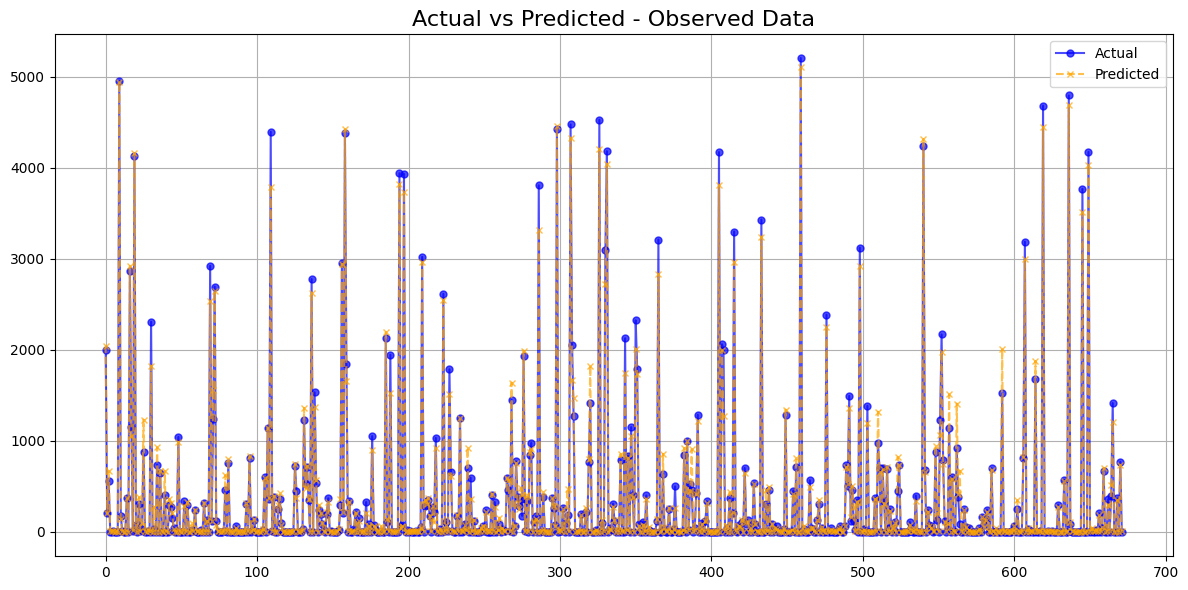

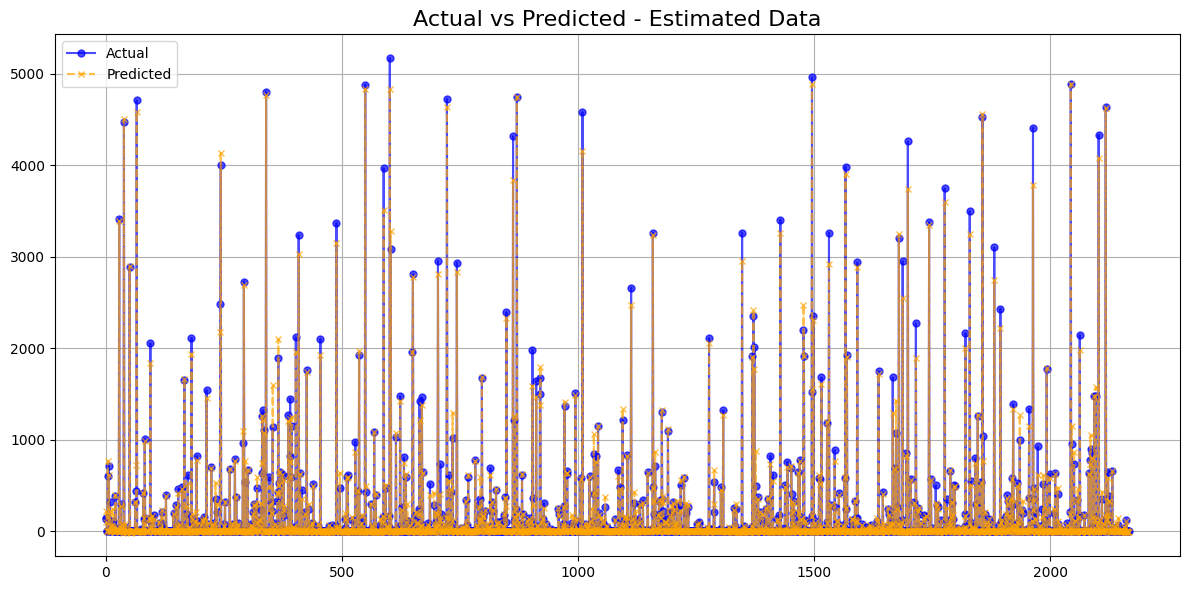

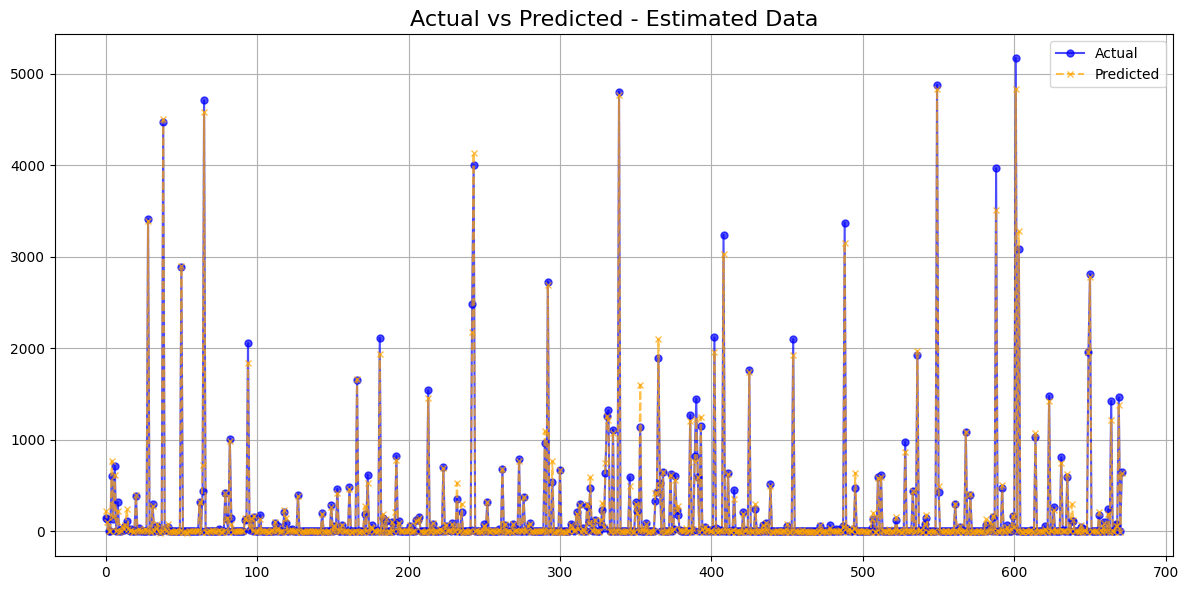

In [15]:
import matplotlib.pyplot as plt
train_prediction = multi_predict(x_whole, reg_models)

test_prediction = multi_predict(X_val_est_combined, reg_models)
# Observed Data
# Set up the plotting area
plt.figure(figsize=(12, 6))
# Line plot of Actual values
plt.plot(y_whole.reset_index(drop=True), label='Actual', linestyle='-', marker='o', markersize=5, alpha=0.7, color='blue')
# Line plot of Predicted values
plt.plot(train_prediction, label='Predicted', linestyle='--', marker='x', markersize=5, alpha=0.7, color='orange')
# Titles and labels
plt.title('Actual vs Predicted - Observed Data', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualise the monthly predictions
# Observed Data
plt.figure(figsize=(12, 6))
# Line plot of Actual values
plt.plot(y_whole.reset_index(drop=True)[:24*7*4], label='Actual', linestyle='-', marker='o', markersize=5, alpha=0.7, color='blue')
# Line plot of Predicted values
plt.plot(train_prediction[:24*7*4], label='Predicted', linestyle='--', marker='x', markersize=5, alpha=0.7, color='orange')
# Titles and labels
plt.title('Actual vs Predicted - Observed Data', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Estimated Data
# Set up the plotting area
plt.figure(figsize=(12, 6))
# Line plot of Actual values
plt.plot(y_val_est_combined.reset_index(drop=True), label='Actual', linestyle='-', marker='o', markersize=5, alpha=0.7, color='blue')
# Line plot of Predicted values
plt.plot(test_prediction, label='Predicted', linestyle='--', marker='x', markersize=5, alpha=0.7, color='orange')
# Titles and labels
plt.title('Actual vs Predicted - Estimated Data', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Visualise the monthly predictions
# Estimated Data
plt.figure(figsize=(12, 6))
# Line plot of Actual values
plt.plot(y_val_est_combined.reset_index(drop=True)[:24*7*4], label='Actual', linestyle='-', marker='o', markersize=5, alpha=0.7, color='blue')
# Line plot of Predicted values
plt.plot(test_prediction[:24*7*4], label='Predicted', linestyle='--', marker='x', markersize=5, alpha=0.7, color='orange')
plt.title('Actual vs Predicted - Estimated Data', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Save model

In [16]:
from src.models.saving import save_predictions
from src.features.postprocess_data import postprocess_data

y_predictions = postprocess_data(x_test_whole, pd.Series(y_predictions))

save_predictions(y_predictions, 'xgboost est 3 sample weight')


   id  prediction
0   0    0.000000
1   1    0.120615
2   2    0.209895
3   3   70.030418
4   4  356.526764
